# Project 5 - Object Detection

### Due Date: *Friday, April 5th*

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [LearningSuite](https://learningsuite.byu.edu/). <span style="color:red">PLEASE ONLY SUBMIT THE NOTEBOOK -- I DON'T NEED ANY OF THE OTHER SUPPORTING FILES OR DATA</span>

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below (at the end of this notebook).

Please also fill in here the time that each part took you:
* 1. Part A - Feature Extraction: <span style="color:red;">10 minutes (mostly waiting for it to load)</span>
* 2. Part B - Vector Quantization: <span style="color:red;">15 minutes (mostly waiting for it to load)</span>
* 3. Part C - Classifier Training: <span style="color:red;">2 minutes</span>
* 4. Part D - Sliding Window Detection: <span style="color:red;">n/a</span>
* 5. Part E - Evaluation: <span style="color:red;">1 hour 30 minutes</span>
* 6. Challenges: <span style="color:red;">n/a</span>
* 7. Write-up: <span style="color:red;">10 minutes</span>


## Background - Object Detection

For this assignment, you will implement an object detection pipeline. Your project will leverage a set of training images (both positive examples where the object of interest is present and negative examples where it is not).  Your program will divide a query/test image up into image regions or _windows_ and convert each window into a feature vector representation (based on Bag-of-Words and/or HOG).  Using the training data, you will use a machine-learning algorithm to train a classification model which will predict the probability of each window (its derived feature vector, actually) containing the object to be detected.

This project will apply several of the things you’ve done previously, but also incorporate the idea of supervised machine learning.  You will need to implement both the feature extraction and the classification parts of the pipeline.  Here are the steps that you will follow:

1) Extract and cluster feature descriptors - You will extract features (feature _descriptors_) from a variety of images and cluster them into $K$ discrete clusters (visual words).

2) Vector Quantization - Given the visual vocabulary, each image is converted into a Bag-of-Words representation (a $K$-dimensional histogram).

3) Train Detection Classifier - Given the positive and negative training examples, a Support Vector Machine (SVM) is trained to distinguish between the object and everything else.

4) ~Sliding Window - Finds the actual object in an image by iterative considering windows at different locations and scales.~ <span style="color:red">We will not be doing sliding window detection.</span>


## Data

For this project, we will provide you with a dataset comprised of Birds and Flowers.  Your task will be to detect the birds that are present in a set of test images.

1. Within the main folder, download and setup the CUB-200-2011 (1.1GB) dataset:
```
    wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz
    tar xvfz CUB_200_2011.tgz
    ln -s CUB_200_2011/images .    OR    mv CUB_200_2011/images .
``` 


2. Do the same for the Oxford-Flowers-102 (350MB) dataset:
```
    wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
    tar xvfz 102flowers.tgz
    [the jpg folder should be right there in the directory]
```

3. You should now be able to access the Datasets from within your notebook using the following syntax/commands:

```Python
import cub_dataset
cub_data = cub_dataset.CUB_Dataset()
cub_train = cub_dataset.getTrainingSet()
cub_test = cub_dataset.getTestSet()

for imgnum in cub_train:
    kp,desc = cub_data.getSIFTfeatures(imgnum,bbox_only=True) # Get only the features within the bounding box

# If you wanted to display images, you can get them with...
img1 = cub_train.getImage(1,bbox_only=False) # Get the whole image
img2 = cub_train.getImage(1,bbox_only=True)  # Get only the bounding box


import flowers_dataset
flower_data  = flowers_dataset.Flowers_Dataset()
flower_train = flower_data.getTrainingSet()
flower_test = flower_data.getTestSet()

for imgnum in flower_train:
    kp,desc = flower_data.getSIFTfeatures(imgnum) # The flowers dataset does not include bounding boxes.
```

**Test Set A is composed from these two datasets.** Specifically, it is composed of (i) the positive images, namely those in `cub_data.getTestSet()` and, (ii) the negative images, namely those in `flower_data.getTestSet()`.

~Test Set B is provided with the lab files and contains images with multiple birds in them.~ <span style="color:red">Test Set B is for sliding window detection, which we will not be doing.</span>

**Note:** When you are first implementing the lab, you may find it helpful to only load a subset of the images (ex. the first 100). This will make your code run faster and easier to debug. You can then increase the number of images for your final results once you have implemented the full lab.

### Part A: Extract and Cluster Feature Descriptors

To create the visual vocabulary, you will need to sample (grab a subset) from amongst all the sift descriptors of a large number of images. You want a representative set of descriptors, so you should ideally grab from images of all categories you intend to recognize and also from both the set of
training images and the set of test images. A useful routine for sampling is `numpy.random.permutation(n)[0:m]` which will generate a random subset of $m$ numbers between $0$ and $n-1$. Generate a vector of column indices in this way and use it to grab a subset of $m$ rows from a given image’s descriptor matrix.

So, once you have $m$ descriptors from each image, you will concatenate these together into a single matrix. Each row is a single descriptor, so with SIFT features, this matrix has 128 columns. Let us suppose that there are a total of $M$ rows/descriptors.

Now this matrix represents $M$ distinct points in $R^{128}$. The k-means algorithm will partition these $M$ 128-dimensional points into $K$ clusters, for some value $K$ that is provided. $K$ determines how many words will be in our visual vocabulary. So, you will take his large $M$ x 128 matrix, pass it to k-means along with the desired number of clusters $K$, and kmeans will return a set of $K$ 128-dimensional points each representing the center of one of the clusters. These $K$ points form your visual vocabulary.

Resources that you may find useful:
* [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) [[Examples]](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#examples-using-sklearn-cluster-kmeans)
* [sklearn.cluster.MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html)

In [1]:
%pylab inline
import cub_dataset, flowers_dataset
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import LinearSVC, SVC
import tqdm
import time
import pickle
from functools import partial
import cv2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import threading
class ElapsedTime(threading.Thread):
    '''A context manager for timing long-running functions.
    
    Args:
        message: a prefix message to print along with the elapsed time.
    
    Usage:
        with ElapsedTime("This message will be printed") as track:
            someFunction()  # keep track of how long this function takes
            track.stop()  # IMPORTANT: you must call stop()
    '''
    def __init__(self, message):
        super(ElapsedTime, self).__init__()
        self.message = message
        self._stop_event = threading.Event()

    def stop(self):
        self._stop_event.set()

    def stopped(self):
        return self._stop_event.is_set()

    def run(self):
        thread_start = time.time()
        while not self.stopped():
            print(f"\r{self.message} {time.time()-thread_start:.1f} seconds", end="")
            time.sleep(.999)
        print()
        self.elapsed = time.time()-thread_start
            
    def __enter__(self):
        self.start()
        return self
    
    def __exit__(self, type, value, traceback):
        self.stop()
        self.join()
        return type

In [47]:
# This function is provided for you to sample image descriptors. Please look
# through it and understand what it does.
def sample_descriptors(dataset, img_ids, m=100):
    '''Sample descriptors from images in dataset.
    
    args:
        dataset: the dataset to sample from (cub_dataset.CUB_Dataset or
            flowers_dataset.Flowers_Dataset)
        img_ids: list of integer image ids - the set of images to sample from
        m (int): the max number of descriptors to sample from each image
        
    returns:
        descriptors: a numpy array containing up to n*m rows (n images and up
            to m descriptors from each) and 128 columns.
    '''
    descriptors = []
    for i in tqdm.tqdm(img_ids, desc=dataset.__class__.__name__):
        kp, desc = dataset.getSIFTfeatures(i)
        n_d = desc.shape[0]
        ind = np.random.choice(n_d, min(m, n_d), replace=False)
        descriptors.append(desc[ind])
    descriptors = np.concatenate(descriptors, 0)
    return descriptors

In [4]:
# SET UP THE DATA
cub_data = cub_dataset.CUB_Dataset()
cub_train = cub_data.getTrainingSet()
cub_test = cub_data.getTestSet()
cub_data.getSIFTfeatures = partial(cub_data.getSIFTfeatures, bbox_only=True)

flower_data = flowers_dataset.Flowers_Dataset()
flower_train = flower_data.getTrainingSet()
flower_test = flower_data.getTestSet()

In [37]:
# YOU MAY WANT TO TRY THINGS OUT WITH A SUBSET OF THE IMAGES. IT TAKES A WHILE
# TO RUN THINGS WITH THE FULL SET - BUT YOU'LL PROBABLY GET BETTER RESULTS BY
# USING MORE IMAGES

m = 100  # number of descriptors to sample from each image
num_img = 100 # None  # number of images to use from each dataset - set to None to use all

# UNCOMMENT THESE LINES IF YOU WANT TO GENERATE A NEW SET OF DESCRIPTORS
cub_descriptors = sample_descriptors(cub_data, cub_train[:num_img], m) 
flower_descriptors = sample_descriptors(flower_data, flower_train[:num_img], m)

Flowers_Dataset: 100%|███████████████████████| 100/100 [00:22<00:00,  4.49it/s]


In [6]:
# UNCOMMENT THESE LINES IF YOU WANT TO SAVE THE DESCRIPTORS YOU GENERATED
np.save('user-data/cub-descriptors.npy', cub_descriptors)
np.save('user-data/flower-descriptors.npy', flower_descriptors)

In [3]:
# LOAD SAVED DESCRIPTORS - THEY MUST BE GENERATED FIRST
cub_descriptors = np.load('user-data/cub-descriptors.npy')
flower_descriptors = np.load('user-data/flower-descriptors.npy')
print(cub_descriptors.shape)
print(flower_descriptors.shape)

KeyboardInterrupt: 

In [38]:
# CLUSTER DESCRIPTORS
# Use MiniBatchKMeans to cluster all the training descriptors (combine the 
# cub and flower descriptors)
# You can play with different values of k (number of clusters)
# This may take some time to run. You can try increasing the batch size - it
# may speed things up
# You can use the provided ElapsedTime context manager to keep track of how
# long it takes to run

# clustering code goes here
all_descriptors = np.concatenate([cub_descriptors, flower_descriptors], axis=0)
kmeans = MiniBatchKMeans(200)
kmeans.fit(all_descriptors)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=200, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [9]:
# YOU CAN SAVE THE STATE OF THE KMEANS OBJECT TO LOAD LATER
# SO YOU DON'T HAVE TO RERUN IT
pickle.dump(kmeans, open('user-data/kmeans-state.pkl', 'wb'))

In [ ]:
# YOU LOAD IT LIKE SO
kmeans = pickle.load(open('user-data/kmeans-state.pkl', 'rb'))

### Part B: Vector Quantization - Represent each Image as a Bag-of-Words

Vector Quantization is the process of taking this visual vocabulary (the $K$ cluster centers) and converting the list of descriptors representation into a bag of visual words, a histogram identifying, for each visual word (each bin in the histogram), the fraction of the SIFT descriptors for which that visual word, or cluster center, is the closest one (in the 128-dimensional space).

Each image is thus converted using the visual vocabulary into a histogram with $K$ bins, or equivalently a feature vector with $K$ dimensions. Each descriptor in an image is mapped as a vote for the cluster whose center that given descriptor is closest to.

You can use the KMeans object you trained (fit) in Part A to predict which visual word/cluster each given descriptor is closest to.  Aggregating the cluster predictions for all descriptors in an image or window produces the Bag-of-Visual-Words representation ($K$-dimensional histogram) for the image/window.


![alt text](pipeline.png)

In [11]:
# This function is provided for you to compute bag-of-words descriptors. Please
# look through it and understand what it does. Take a minute to look up
# np.bincount and understand it.
def get_bows(dataset, img_ids, kmeans):
    '''Get a bag-of-words representation for a list of images in a dataset.
    
    args:
        dataset: the dataset to sample from (cub_dataset.CUB_Dataset of
            flowers_dataset.Flowers_Dataset)
        img_ids: list of integer image ids - the set of images to sample from
        kmeans: an sklearn.cluster.MiniBatchKMeans object that has been fit
            to the training data
    
    returns:
        bow: an (n x k) numpy array - n images and k bins (number of clusters
            in kmeans)
    '''
    bow = []
    for i in tqdm.tqdm(img_ids, desc=dataset.__class__.__name__):
        kp, desc = dataset.getSIFTfeatures(i)
        desc = kmeans.predict(desc)
        desc = np.bincount(desc, minlength=kmeans.n_clusters)
        desc = desc / desc.sum()
        bow.append(desc)
    bow = stack(bow, 0)
    return bow

The following code is pretty trivial, so I'm just giving it to you.

In [29]:
cub_trn_bow = get_bows(cub_data, cub_train[:num_img], kmeans)
flower_trn_bow = get_bows(flower_data, flower_train[:num_img], kmeans)

Flowers_Dataset: 100%|███████████████████████| 100/100 [00:09<00:00, 10.41it/s]


In [13]:
np.save('user-data/cub-train-bow.npy', cub_trn_bow)
np.save('user-data/flower-train-bow.npy', flower_trn_bow)

In [2]:
cub_trn_bow = np.load('user-data/cub-train-bow.npy')
flower_trn_bow = np.load('user-data/flower-train-bow.npy')

### Part C: Train the Detection Classifier

To perform detection, you will be using supervised machine learning to train a binary classifier using the labeled data that you're given (positive image windows with the object to be detected, negative image windows without the object).  We will be using Support Vector Machines (SVMs) as our classifier for this project. To train the SVM, you provide a set of feature vectors in the form of a matrix (the size is $N\times K$, where $N$ is the total number of training images, both positive and negative) and a corresponding label vector (generally $+1$ at the indices where the feature vector is from the positive set and $-1$ corresponding to the indices of the negative feature vectors).

Resources that you may find useful:
* [Support Vector Machines (sklearn.svm)](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
    * [User Guide](https://scikit-learn.org/stable/modules/svm.html#svm) and  [Tips on Practical Use](https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use)
    * [Another Tutorial](https://www.learnopencv.com/svm-using-scikit-learn-in-python/)
* [OpenCV SVM Class](https://docs.opencv.org/3.4.1/d1/d2d/classcv_1_1ml_1_1SVM.html)
    * [OpenCV SVM Tutorial](https://docs.opencv.org/3.4/d3/d02/tutorial_py_svm_index.html)



We're going to need to load up descriptors for our test set -- now's a good time to do that.

In [30]:
cub_tst_bow = get_bows(cub_data, cub_test[:num_img], kmeans)
flower_tst_bow = get_bows(flower_data, flower_test[:num_img], kmeans)

Flowers_Dataset: 100%|███████████████████████| 100/100 [00:09<00:00, 10.35it/s]


In [16]:
np.save('user-data/cub-test-bow.npy', cub_tst_bow)
np.save('user-data/flower-test-bow.npy', flower_tst_bow)

In [3]:
cub_tst_bow = np.load('user-data/cub-test-bow.npy')
flower_tst_bow = np.load('user-data/flower-test-bow.npy')

In [4]:
# SET UP THE DATA
train_data = np.concatenate((cub_trn_bow, flower_trn_bow), 0)
train_labels = np.concatenate([
    np.ones(cub_trn_bow.shape[0]), np.zeros(flower_trn_bow.shape[0])])

test_data = np.concatenate((cub_tst_bow, flower_tst_bow),0)
test_labels = np.concatenate([
    np.ones(cub_tst_bow.shape[0]), np.zeros(flower_tst_bow.shape[0])])

In [5]:
# TRAIN THE SVM CLASSIFIER
# The LinearSVC is a really fast implementation of an SVM with a linear kernel.
# You can get decent results with it. The SVC is slower to train, but you can
# choose non-linear kernels which may give better results.

svm = SVC()
svm.fit(train_data, train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [6]:
# The score function will tell you the overall classification accuracy of
# the classifier on a set of data.
print(svm.score(train_data, train_labels))
print(svm.score(test_data, test_labels))

0.972
0.9321428571428572


### Part D: Evaluation

Recall the two test sets that were described above. We will use them for different ways to measure the effectivness of our algorithm:

* Set A - This set contains thousands of images, each containing either a bird or something else. Set A is to gauge the accuracy of your detector.  _You will not need to do sliding window on this set. Use the full image and simply predict bird vs. not bird_.

* ~Set B - This set contains only 12 images, but each image has multiple birds present. On this set, you *will* use sliding window detection, trying to detect the locations of each bird present.~

For Set A, you will generate a Precision-Recall curve. Accuracy will be judged by the Area Under the Curve (AUC) metric.  You should use `scikit-learn`'s [`auc()` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc) to compute this value.  For The PR curves themselves, however, you will need to do the calculations of the curve yourself. You may use scikit-learn's built-in curve for comparison when debugging, but your final results must use your implementation.

The student in the class with the best accuracy on Test Set A, as measured by AUC, will receive 10 points of extra credit.

Resources for P-R Curves that you may find useful:
* scikit-learn's page on [Precision-Recall](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)
* scikit-learn's [`precision-recall-curve()` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve)

~For Set B, you will simply run your sliding window on each image, noting the total number of birds you detect per image. Plot your bounding boxes for each image in the dataset.~


**Calculating a P-R Curve.** You will need a continuous-valued score for each image in the test set -- not just a binary classification decision. You can use the `svm.decision_function` function to calculate these values. To generate the curve, sort the samples by their score -- highest to lowest. For a variety of different thresholds, calculate the precision and recall. The threshold just means that you call anything with a higher score a "positive" (label 1). 

Note that as your threshold gets lower, your precision will tend downward and your recall will tend upward. You'll have minimum recall at your maximum threshold, and minimum precision at your minimum threshold.

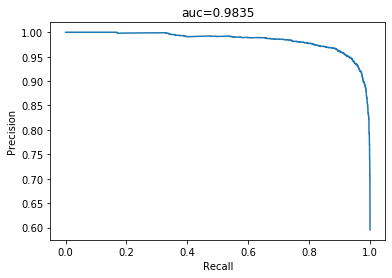

In [7]:
# CALCULATE A P-R CURVE FOR YOUR TEST DATA, AND MEASURE AUC
# While at first it may seem like you need to loop over a bunch of threshold
# values, there is actually a nice vectorized way to do this (surprise!). Can
# you figure out what it is? Hint: use every image's score as a different
# threshold.

from sklearn.metrics import auc, precision_recall_curve, plot_precision_recall_curve
test_scores = svm.decision_function(test_data)

indexes = argsort(test_scores)
labels, thresholds = test_labels[indexes], test_scores[indexes]
xx, yy = numpy.meshgrid(range(len(thresholds)), range(len(thresholds)))
putative_labels = (xx >= yy).astype(float) # labels at each threshold

tp = (putative_labels * labels[None, :]).sum(axis=1)
fp = (putative_labels * (1 - labels[None, :])).sum(axis=1)
fn = ((1 - putative_labels) * labels[None, :]).sum(axis=1)

precision = tp / (tp + fp)
recall = tp / (tp + fn)

xlabel("Recall")
ylabel("Precision")
title("auc={:.4f}".format(auc(recall, precision)))
plot(recall, precision)

## Grading and Challenges
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Extract and Cluster Feature Descriptors.
* [20 pts] Vector Quantization - Represent each Image as a Bag-of-Words.
* [25 pts] Train the Detection Classifier.
* [35 pts] Evaluation
  - Include a plot of your P-R Curve
  - Clearly report your AUC accuracy

*As noted above, the person with the highest detection accuracy on Test Set A will receive 10 points extra credit.*

### OPTIONAL Challenge

1) [20 points extra credit] Use color histograms to improve detection performance.  You can generate a color histogram and concatenate it onto the Bag-of-Words representation for a given image.  Concatenating features is very common.  If you choose to do this, please plot 3 curves in the same figure: the BofW by itself, the Color Histograms by themselves and the combined BoFW/ColorHist.

## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* How well did you do on test set A? What additional things would you have done to improve the AUC?
* How well did you detect multiple birds in test set B? How would you increase your accuracy of detection in images like these?
* What improvements would you recommend for this lab?

### My Write-up
* The most difficult part of the lab was calculating the P-R curve.  This was the most difficult part because it was basically the only part we had to do ourselves.
* I had decent results (over 84% accuracy).  My AUC was about 0.938, which I thought was pretty good.  I noticed that using more images in the training set did the most to improve my accuracy and AUC.
* This part was not required.
* This lab was fairly easy to do, but took a long time to get descriptors and histograms for the images.  It would be nice to have a quicker way to do that.